In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
def load_document_image(image_path):
    """
    Load the provided image and display basic information about it.
    """
    # Load the image
    image = cv2.imread(image_path)

    # Convert from BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # Basic information about the image
    dimensions = image.shape
    pixel_min = image.min()
    pixel_max = image.max()
    pixel_mean = image.mean()

    # Histogram of pixel intensity
    plt.figure(figsize=(6, 6))
    plt.hist(image.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

    # Print image details
    print(f"Image Dimensions: {dimensions}")
    print(f"Pixel Value Range: {pixel_min} to {pixel_max}")
    print(f"Mean Pixel Value: {pixel_mean:.2f}")

    return image

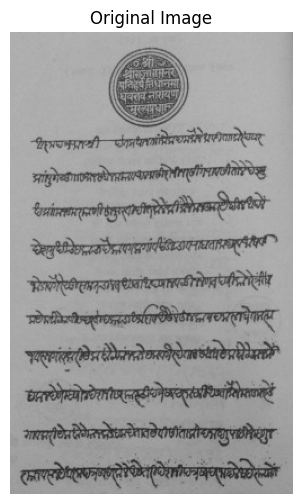

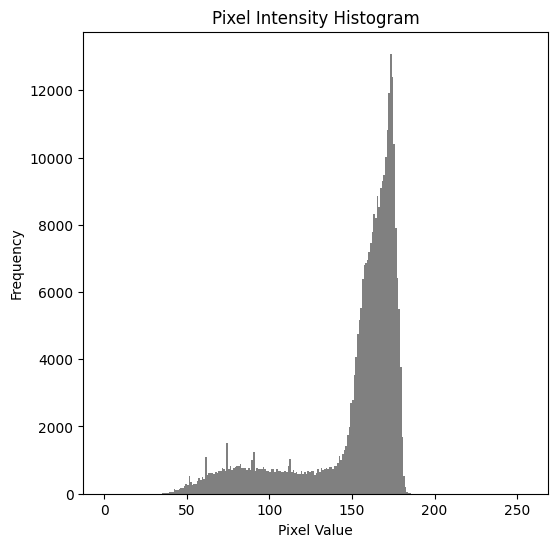

Image Dimensions: (411, 251, 3)
Pixel Value Range: 28 to 190
Mean Pixel Value: 150.76


In [5]:
# Load and explore the image
image_path = "historical-doc.png"
image = load_document_image(image_path)

## 3.2.1 Rectangular Bounding Box Detection

In [7]:
def preprocess_image(image):

    # Step 1: Convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis("off")
    plt.show()

    # Step 2 : Apply Gaussian Blur to remove noise
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_blur, cmap='gray')
    plt.title("Gaussian Blur")
    plt.axis("off")
    plt.show()

    # Step 2: Apply binary inverse thresholding 
    # 144: Threshold value. Pixels above this value are set to 0, and those below are set to maxval.
    # 255: Maximum value to use with the cv2.THRESH_BINARY_INV thresholding type.

    _, thresh2 = cv2.threshold(img_blur, 144, 255, cv2.THRESH_BINARY_INV)
    plt.figure(figsize=(6, 6))
    plt.imshow(thresh2, cmap='gray')
    plt.title("Binary Inverse Thresholding")
    plt.axis("off")
    plt.show()


    # Step 3: Apply dilation to connect text lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))  # Horizontal kernel
    mask = cv2.morphologyEx(thresh2, cv2.MORPH_DILATE, kernel)
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap='gray')
    plt.title("Dilated Image (Text Lines Connected)")
    plt.axis("off")
    plt.show()

    return mask  # Return the preprocessed image (dilated mask)

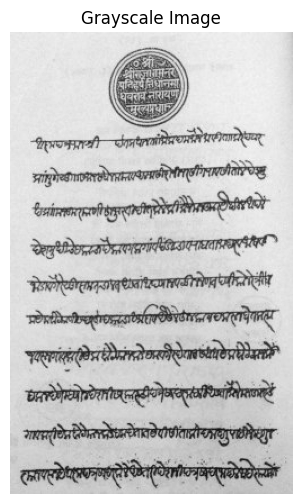

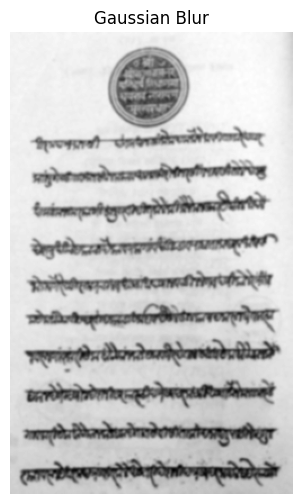

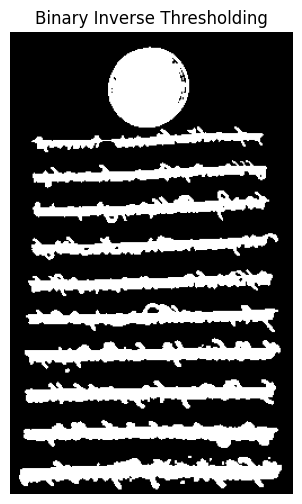

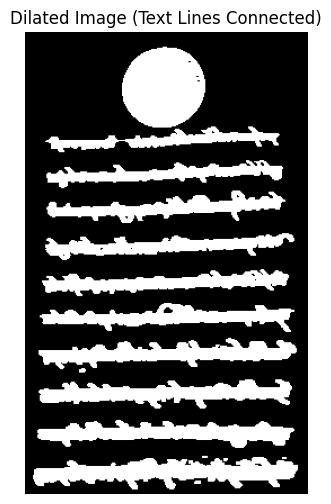

In [8]:
mask=preprocess_image(image)

In [9]:
def detect_lines_with_bboxes(mask,image):
    # Step 4: Find contours
    bboxes = []  # To store bounding box coordinates
    bboxes_img = image.copy()  # Copy the original image for visualization
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # Step 5: Process each contour to extract bounding boxes
    for cntr in contours:
        x, y, w, h = cv2.boundingRect(cntr)

        # Filter small artifacts based on width and height
        if w > 10 and h > 1:  # Threshold values for valid text lines
            # Draw bounding box on the image for visualization
            cv2.rectangle(bboxes_img, (x, y), (x + w, y + h), (0, 0, 255), 1)
            bboxes.append((x, y, w, h))

    # Display the bounding boxes on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(bboxes_img, cv2.COLOR_BGR2RGB))
    plt.title("Bounding Boxes on Text Lines")
    plt.axis("off")
    plt.show()

    return bboxes  

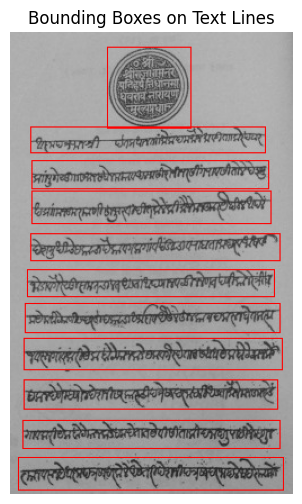

In [10]:
bboxes=detect_lines_with_bboxes(mask,image)

## Performance Analysis of Rectangular Bounded Algorithm

Performance:

- Works well for structured documents with clear text lines.

- Efficient and computationally less expensive.

Failure Cases:

- Merged Lines: Closely spaced lines may merge due to over-dilation.

- Artifacts: Small noise regions might be falsely detected as text lines.

- Orientation: Poor handling of curved or angled text lines.


In [105]:
def save_cropped_lines(image, bboxes):
    output_dir = 'Lines'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save each detected text line as a separate image
    for idx, (x, y, w, h) in enumerate(bboxes):
        # Add padding to avoid clipping text
        padding = 10
        x1, y1 = max(0, x - padding), max(0, y - padding)
        x2, y2 = min(image.shape[1], x + w + padding), min(image.shape[0], y + h + padding)

        # Crop the region of interest
        cropped_line = image[y1:y2, x1:x2]

        # Save the cropped text line
        output_path = os.path.join(output_dir, f'line_{idx + 1}.jpg')
        cv2.imwrite(output_path, cropped_line)

    print(f"Saved {len(bboxes)} cropped text lines in '{output_dir}' directory.")

In [106]:
save_cropped_lines(image, bboxes)

Saved 11 cropped text lines in 'Lines' directory.


### Justification of Preprocessing Techniques and Parameters

#### Grayscale Conversion
- **Technique**: Convert the image to grayscale.
- **Parameter**: None.
- **Impact**: Simplifies the image by removing color information, making it easier to process for text detection.

#### Gaussian Blur
- **Technique**: Apply Gaussian Blur.
- **Parameter**: Kernel size (5, 5).
- **Impact**: Reduces noise and smooths the image, which helps in better thresholding and contour detection.

#### Binary Inverse Thresholding
- **Technique**: Apply binary inverse thresholding.
- **Parameter**: Threshold value (144), max value (255).
- **Impact**: Converts the image to binary, highlighting text regions as white and background as black, facilitating easier text line detection.

#### Dilation
- **Technique**: Apply dilation.
- **Parameter**: Kernel size (3, 1).
- **Impact**: Connects broken parts of text lines, making them more continuous and easier to detect as single contours.

### Analysis of Impact on Image and Suitability for Text Line Detection
- **Grayscale Conversion**: Essential for reducing computational complexity and focusing on intensity variations.
- **Gaussian Blur**: Helps in reducing high-frequency noise, making the subsequent thresholding step more effective.
- **Binary Inverse Thresholding**: Crucial for separating text from the background, ensuring that text regions are prominently highlighted.
- **Dilation**: Enhances the connectivity of text lines, reducing the chances of fragmented detection and improving the accuracy of bounding box generation.

Overall, these preprocessing steps and parameters are chosen to enhance the clarity and connectivity of text lines, making the image more suitable for accurate and efficient text line detection.

In [ ]:
image=load_document_image(image_path)

## Line Segmentation Within Circular Arcs

In [11]:
def segment_lines_in_seal(image):
    # Step 1: Convert the image to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Display the grayscale image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB))
    plt.title("Grayscale Image")
    plt.axis("off")
    plt.show()

    # Step 2: Detect circles in the image using Hough Circle Transform
    circles = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=15, maxRadius=30)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        print(f"Detected {len(circles)} circles.")
        
        # Step 3: Display the circles drawn on the image for visualization
        output_image = image.copy()  # Make a copy of the original image to draw circles on
        circle = circles[0]  # Consider only the first detected circle
        x, y, r = circle  # Circle center (x, y) and radius (r)
        cv2.circle(output_image, (x, y), r, (0, 255, 0), 1)  # Draw the circle in green with thickness 1

        # Show the image with circles overlaid
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title("Detected Circular Seals")
        plt.axis("off")
        plt.show()

        # Step 4: Focus on the first detected circle (seal)
        x, y, r = circle  # Circle center (x, y) and radius (r)

        # Step 5: Create a mask to isolate the circular region
        mask = np.zeros_like(img_gray)
        cv2.circle(mask, (x, y), r, 255, -1)  # Draw the circle on the mask

        # Display the mask
        plt.figure(figsize=(6, 6))
        plt.imshow(mask, cmap='gray')
        plt.title("Mask for Circular Region")
        plt.axis("off")
        plt.show()

        # Step 6: Apply the mask to the image to focus on the circular region
        masked_img = cv2.bitwise_and(image, image, mask=mask)

        # Display the masked image
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
        plt.title("Masked Circular Region")
        plt.axis("off")
        plt.show()

        # Step 7: Apply preprocessing (thresholding, dilation) on the masked image
        _, thresh = cv2.threshold(cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY), 160, 255, cv2.THRESH_BINARY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))  
        dilated_img = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

        # Display the dilated image
        plt.figure(figsize=(6, 6))
        plt.imshow(dilated_img, cmap='gray')
        plt.title("Dilated Image")
        plt.axis("off")
        plt.show()

        # Step 8: Find contours in the dilated image
        contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Step 9: Create a directory to save segmented lines
        output_dir = 'Segmented_Lines_Circle'
        os.makedirs(output_dir, exist_ok=True)

        print(f"Detected {len(contours)} lines within the circular region.")
            
        # Step 10: Process each contour and save the segmented lines within the circular region
        line_counter = 1
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            print(f"Line {line_counter}: ( w={w}, h={h})")

            # Filter contours that are too small (likely noise)
            if w > 10 and h >=3:
                # Crop the line within the circle
                cropped_line = image[y:y + h, x:x + w]
                
                # Save the cropped line image
                output_path = os.path.join(output_dir, f'circle_line_{line_counter}.png')
                cv2.imwrite(output_path, cropped_line)
                print(f"Saved {output_path}")
                line_counter += 1

                # Step 11: Draw bounding boxes on the circular region
                cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 0, 255), 1)  # Draw red rectangle

        # Step 12: Show the image with bounding boxes overlaid on the circular region
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title("Bounding Boxes in Circular Region")
        plt.axis("off")
        plt.show()

    else:
        print("No circles were detected.")

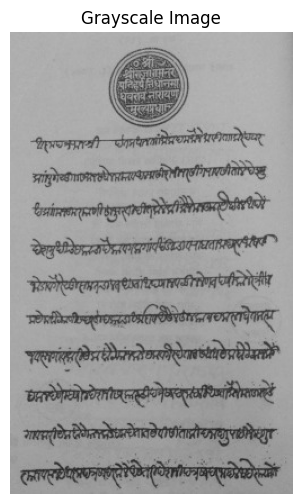

Detected 1 circles.


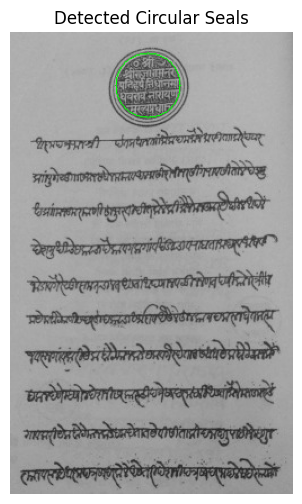

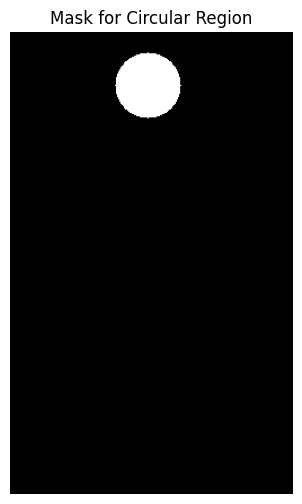

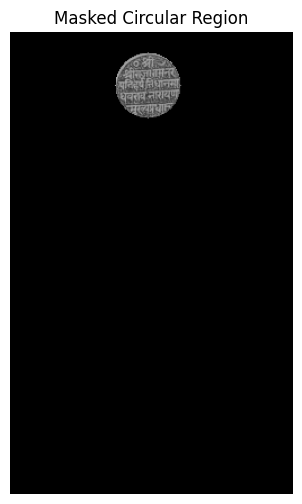

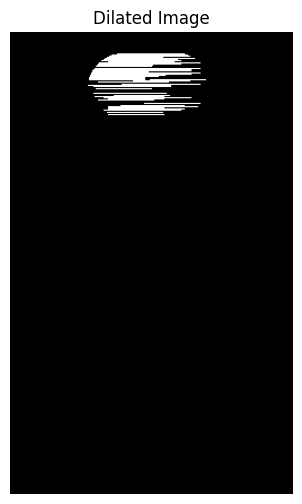

Detected 10 lines within the circular region.
Line 1: ( w=50, h=1)
Line 1: ( w=50, h=1)
Line 1: ( w=84, h=5)
Saved Segmented_Lines_Circle/circle_line_1.png
Line 2: ( w=50, h=1)
Line 2: ( w=86, h=5)
Saved Segmented_Lines_Circle/circle_line_2.png
Line 3: ( w=65, h=1)
Line 3: ( w=50, h=1)
Line 3: ( w=100, h=3)
Saved Segmented_Lines_Circle/circle_line_3.png
Line 4: ( w=104, h=13)
Saved Segmented_Lines_Circle/circle_line_4.png
Line 5: ( w=93, h=12)
Saved Segmented_Lines_Circle/circle_line_5.png


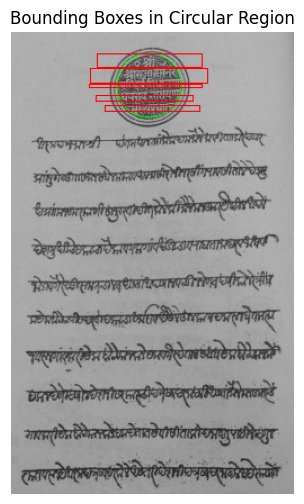

In [12]:
segment_lines_in_seal(image)

## Challenges of Segmenting Lines Inside the Seal

- Line Proximity: Lines within the seal are often very close, leading to merging during dilation.

- Kernel Size: Selecting an appropriate kernel size is difficult; small kernels miss connections, while large ones cause merging.

- Blur and Noise: Blurriness and faint lines make adaptive thresholding and edge detection challenging.

- Circular Mask: Restricting operations to the circular region complicates preprocessing and segmentation.


## 3.3 Tighter Polygonal Boundary Detection

In [257]:
def detect_lines_with_polygons(mask, image):
    """
    Detect and visualize polygonal boundaries around text lines.
    
    Args:
        mask (numpy.ndarray): Preprocessed binary mask of the image.
        image (numpy.ndarray): Original input image.
    
    Returns:
        polygons (list): List of polygonal boundaries for each detected text line.
    """
    polygons = []  # To store polygonal boundaries
    polygons_img = image.copy()  # Copy the original image for visualization

    # Find contours
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # Process each contour
    for cntr in contours:
        # Approximate the contour to a polygon
        epsilon = 0.015 * cv2.arcLength(cntr, True)  # Parameter to control approximation accuracy
        polygon = cv2.approxPolyDP(cntr, epsilon, True)

        # Filter out small artifacts based on the area
        if cv2.contourArea(polygon) > 50:  # Threshold area to filter noise
            # Draw the polygon on the image for visualization
            cv2.polylines(polygons_img, [polygon], isClosed=True, color=(0, 255, 0), thickness=1)
            polygons.append(polygon)

    # Display the original image with polygonal boundaries overlaid
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(polygons_img, cv2.COLOR_BGR2RGB))
    plt.title("Polygonal Boundaries on Text Lines")
    plt.axis("off")
    plt.show()

    return polygons

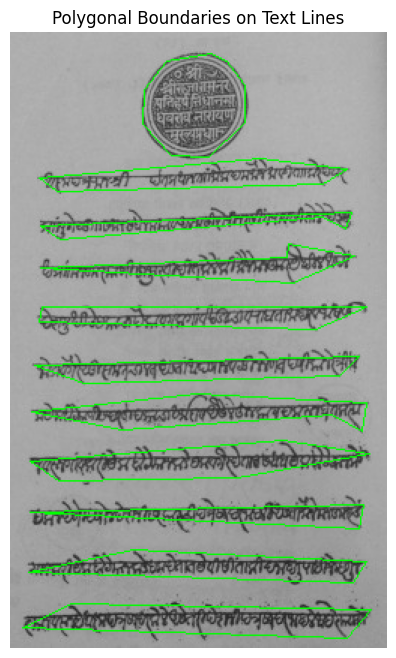

In [258]:
# Detect polygonal boundaries
polygons = detect_lines_with_polygons(mask, image)


## Comparison: Polygonal Boundaries vs. Rectangular Bounding Boxes

Advantages of Polygons:

- Provide tighter, more accurate boundaries, especially for irregular or curved text.

- Better distinguish closely spaced text lines or non-rectangular shapes.

Disadvantages of Polygons:

- More computationally intensive than rectangles.

- Harder to interpret and work with programmatically.

- Can overfit noise or irregularities in contours.

Impact on Results:

- Polygons improve accuracy for complex layouts like seals but offer minimal advantage for structured text regions.

- Over-segmentation might occur in noisy images or irregularly shaped regions.